In [1]:
# Check environment

from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.


/Users/burkeobrien/opt/anaconda3/envs/ds_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[ OK ] shap version 0.40.0 is installed.


In [2]:
# import packages

import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sb
from sklearn.model_selection import train_test_split 


In [3]:
# load dataset

df = pd.read_csv("../data/audi.csv")

### Preprocessing

**Splitting**

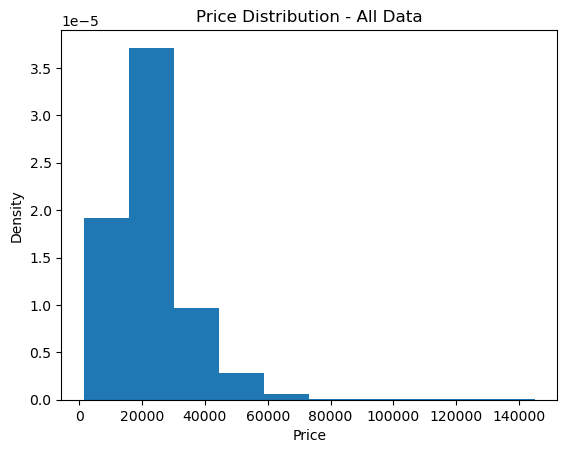

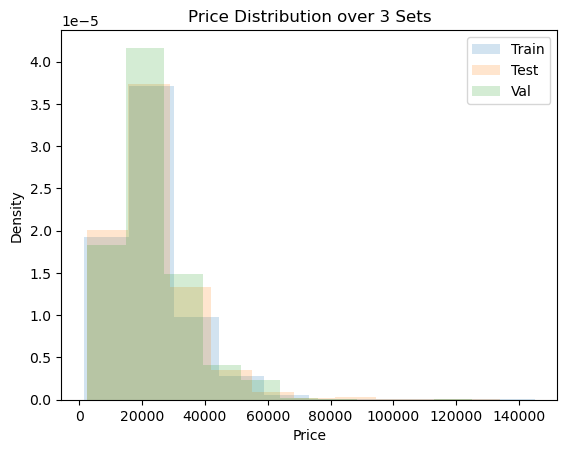

In [4]:
# Our dataset is large enough where we can just use a basic stratified split
random_state = 42

# separate out target variable
y = df['price']
X = df.loc[:, df.columns != 'price']

# We're going to want to stratify on price. 
# I log the outcome so that our bin sizes are larger for more expensive cars
y_binned = pd.qcut(np.log(df['price']), q=10)

# first split to separate out the test set - set test to 10%
X_train, X_other, y_train, y_other = train_test_split(X,y,\
                    train_size = 0.8,random_state = random_state, shuffle = True)

y_binned = pd.qcut(np.log(y_other), q=10)

# second split to separate out the test, val sets - each get 5%
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
                    train_size = 0.5,random_state = random_state, shuffle = True)

# Check distributions- looks good!
plt.hist(y, density = True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Price Distribution - All Data')
plt.savefig('../figures/all_price_histogram.png')
plt.show()

plt.hist(y_train, alpha = 0.2, label = ('Train'), density = True)
plt.hist(y_test, alpha = 0.2, label = ('Test'), density = True)
plt.hist(y_val, alpha = 0.2, label = ('Val'), density = True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Price Distribution over 3 Sets')
plt.legend()
plt.savefig('../figures/sets_price_histogram.png')
plt.show()


**Preprocessing - Feature Engineering**

In [5]:
X_train['log_mileage'] = np.log(X_train['mileage'])
X_test['log_mileage'] = np.log(X_test['mileage'])
X_val['log_mileage'] = np.log(X_train['mileage'])

X_train['log_mpg'] = np.log(X_train['mpg'])
X_test['log_mpg'] = np.log(X_test['mpg'])
X_val['log_mpg'] = np.log(X_train['mpg'])

In [6]:
# Create the preprocess ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# categorical features
onehot_ftrs = ['model','fuelType','transmission']

# continuous with well-defined min/max
minmax_ftrs = ['year', 'engineSize']
# continuous better suited for StandardScaler
std_ftrs = ['tax', 'mileage', 'mpg', 'log_mileage']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('onehot' , OneHotEncoder(sparse=False, handle_unknown = 'ignore'), onehot_ftrs)
    ], remainder = 'passthrough', verbose_feature_names_out = False)

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 


X_train_prep = pd.DataFrame(clf.fit_transform(X_train), columns = clf.get_feature_names_out())
X_val_prep = pd.DataFrame(clf.transform(X_val),  columns = clf.get_feature_names_out())
X_test_prep = pd.DataFrame(clf.transform(X_test),  columns = clf.get_feature_names_out())




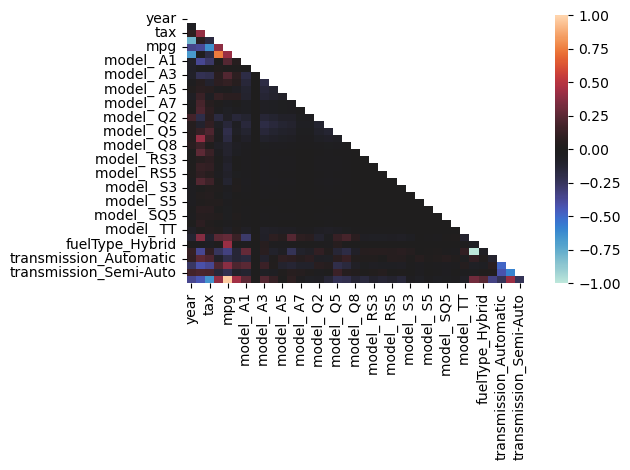

In [9]:
# some interesting correlations here- may need to drop some features

corr_m = X_train_prep.corr()
mask = np.triu(corr_m)

ax = sb.heatmap(corr_m, annot=False, center = 0,mask = mask, vmin = -1, vmax = 1)

plt.tight_layout()
plt.savefig('../figures/final_correlation_matrix.png')


In [8]:
print(X_train_prep.shape)

(8534, 38)
